In [261]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score

from sklearn.model_selection import train_test_split, cross_val_score,  cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import TransformerMixin, BaseEstimator

# Prediction of Soil Viability for Sustainable Agriculture

🎯 The goal of this challenge is to train a model that classifies soils as viable or not for sustainable agriculture.

💡 As part of an initiative to promote sustainable agriculture worldwide, experiments were made at different locations.

Each experiment consisted in an analysis of the soil.  
The results of these analysis are our features.

After the analysis, a small agriculture project was launched at the location:    
- If the project was successful, the soil was labeled as viable.  
- On the other hand if the project failed, the soil was labeled as not-viable.  

The viability of the soil is our target.

💡 Small test projects were used for data collection, but the ambition is to launch projects of much larger scale.  

The costs and time investment on these large scale projects are extremely high.  

🎯 To be valuable, our model should be right at least 90% of the time when it identifies a viable soil.

Here is a description of the fields:
- **id**: Unique identification number of the experiment
- **scientist**: Name of the scientist responsible for the experiment
- **measure_index**: Engineered measure of soil characteristics
- **measure_moisture**: Moisture level of the soil
- **measure_temperature**: Temperature of the soil, in Celsius degrees
- **measure_chemicals**: Indice of chemicals presence in the soil
- **measure_biodiversity**: Indice of biodiversity in the soil
- **measure_flora**: Indice of diversity of flora in the soil
- **main_element**: Symbol of the main chemical element found in the soil
- **past_agriculture**: Indicates the presence of past agriculture on the soil
- **soil_condition**: Overall indicator of the soil fertility
- **datetime_start**: Timestamp of experiment's start 
- **datetime_end**: Timestamp of experiment's end
- **target**: Viability of the soil  
    - 1: means the soil was viable, i.e. the test project was a success  
    - 0: means the soil was not viable, i.e. the test project was a failure

## Data Collection

**📝 Load the csv provided at this URL: https://wagon-public-datasets.s3.amazonaws.com/certification/soils_viability/soils_viability_train.csv.**

In [313]:
# YOUR CODE HERE
data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification/soils_viability/soils_viability_train.csv")

**📝 Clean the dataset and store the resulting dataset in the `data` variable:**

In [314]:
# YOUR CODE HERE
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8302 entries, 0 to 8301
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    8302 non-null   int64  
 1   scientist             8302 non-null   object 
 2   measure_index         8302 non-null   float64
 3   measure_moisture      8295 non-null   float64
 4   measure_temperature   8285 non-null   float64
 5   measure_chemicals     8284 non-null   float64
 6   measure_biodiversity  8284 non-null   float64
 7   measure_flora         78 non-null     float64
 8   main_element          8302 non-null   object 
 9   past_agriculture      4955 non-null   object 
 10  soil_condition        8302 non-null   object 
 11  datetime_start        8302 non-null   object 
 12  datetime_end          8302 non-null   object 
 13  target                8302 non-null   int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 908.2+ KB


In [315]:
data.isnull().sum()

id                         0
scientist                  0
measure_index              0
measure_moisture           7
measure_temperature       17
measure_chemicals         18
measure_biodiversity      18
measure_flora           8224
main_element               0
past_agriculture        3347
soil_condition             0
datetime_start             0
datetime_end               0
target                     0
dtype: int64

In [316]:
data = data.drop(['measure_flora', 'past_agriculture'], axis=1)

In [317]:
data.datetime_start = pd.to_datetime(data.datetime_start)
data.datetime_end = pd.to_datetime(data.datetime_end)

In [318]:
data.main_element.value_counts()

Ca    1099
Al    1048
C     1039
O     1030
Na    1023
Si    1023
Fe    1021
K     1015
Es       4
Name: main_element, dtype: int64

In [319]:
data = data.drop_duplicates().reset_index(drop=True)
data

,id,scientist,measure_index,measure_moisture,measure_temperature,measure_chemicals,measure_biodiversity,main_element,soil_condition,datetime_start,datetime_end,target
0,493,Kathryn Owens,1.875085,24.442232,18.510316,5.715697,521.074105,Na,normal,2017-06-27 16:53:42,2017-06-27 20:05:36,1
1,2340,Andrea Pratt,7.658911,30.121175,17.050250,1.973804,314.443474,Ca,rich,2018-12-10 07:06:56,2018-12-10 11:43:29,1
2,5434,Kaitlyn Jackson,18.000212,34.188025,17.157393,3.658506,361.796180,Al,normal,2018-10-04 18:45:29,2018-10-04 23:20:38,0
3,2304,Brett Rosario,4.056764,37.462768,13.275961,6.666983,402.016494,Ca,normal,2018-10-03 08:03:36,2018-10-03 10:56:40,0
4,1911,Craig Thompson,53.271676,31.425482,17.433458,1.940748,978.383654,Si,poor,2018-07-20 09:27:34,2018-07-20 13:48:30,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8133,6275,James Carter,6.616369,999.000000,17.283441,7.693774,683.214251,Al,poor,2017-04-23 04:10:57,2017-04-23 06:11:58,0
8134,9851,Benjamin Rodriguez,23.578767,999.000000,18.456903,1.009824,313.740816,O,rich,2017-07-21 16:57:54,2017-07-21 20:30:17,1
8135,1453,Colin Baxter,9.967761,999.000000,14.949271,3.484480,370.533784,O,rich,2017-01-07 04:00:02,2017-01-07 06:26:16,1
8136,4265,Christina Ortega,5.195543,999.000000,21.811990,2.261112,403.970941,Si,poor,2018-12-12 10:12:04,2018-12-12 13:02:11,0


### 💾 Save your results

Run the cell below to save your results.

In [320]:
from nbresult import ChallengeResult
results = ChallengeResult(
    "data_cleaning",
    columns=data.columns,
    shape=data.shape,
    samples=data.loc[7000:,:]
)
results.write()

## Target, Baseline & Metrics

**📝 Check the number of target classes and their repartition.**

In [321]:
# YOUR CODE HERE
data.target.describe()

count    8138.000000
mean        0.502826
std         0.500023
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

❓ Is the dataset balanced?

Yes the dataset is balanced with ~50% of the dataset for both classes.

🎯 Recall our initial requirement:

**"To be valuable, our model should be right at least 90% of the time when it predicts a viable soil."**

📝 Store the name of the metric we should use for this purpose in a variable `metric` from the list proposed by [Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values).


In [322]:
# YOUR CODE HERE
metric = 'recall'

**📝 Compute the baseline score and store the result as a floating number in the `baseline_score` variable.**


In [323]:
# YOUR CODE HERE
dummy_classifier = np.random.choice([0, 1], size=data.shape[0])
baseline_score = recall_score(data.target, dummy_classifier)
baseline_score

0.5034213098729228

**📝 Store the target in a variable named `y`.**

In [324]:
# YOUR CODE HERE
y = data.target.to_numpy()

In [325]:
y

array([1, 1, 0, ..., 1, 0, 1])

### 💾 Save your results

Run the cell below to save your results.

In [326]:
results = ChallengeResult(
    "baseline",
    metric=metric,
    baseline=baseline_score
)
results.write()

## Features

In [327]:
from sklearn import set_config; set_config(display='diagram')

**📝 Store the features in a DataFrame `X`.**


In [328]:
# YOUR CODE HERE
X = data.drop(['target'], axis=1)

💡 Two features in there are useless.

- `id`: serves a technical need and does not carry any information.  
- `scientist`: almost all experiments were conducted by different scientists, we assume they all followed the same protocol for the experiment.

**📝 Drop these two features.**

In [329]:
# YOUR CODE HERE
X.drop(['id', 'scientist'], axis = 1, inplace=True)

**📝 Create variables to store feature names according to their types.**

- `feat_num`: list of numerical features' name
- `feat_cat` list of categorical features' name
- `feat_time` list of time features' name

In [331]:
# YOUR CODE HERE
feat_num = X.select_dtypes('number').columns.to_list()
feat_cat = X.select_dtypes('object').columns.to_list()
feat_time = X.select_dtypes('datetime').columns.to_list()

In [332]:
feat_num, feat_cat, feat_time

(['measure_index',
  'measure_moisture',
  'measure_temperature',
  'measure_chemicals',
  'measure_biodiversity'],
 ['main_element', 'soil_condition'],
 ['datetime_start', 'datetime_end'])

💡 We will ignore date-like features for the basic preprocessing.

**📝 Create `X_basic` that contains only numerical and categorical features.**


In [333]:
# YOUR CODE HERE
X_basic = X[feat_num+feat_cat]
X_basic

,measure_index,measure_moisture,measure_temperature,measure_chemicals,measure_biodiversity,main_element,soil_condition
0,1.875085,24.442232,18.510316,5.715697,521.074105,Na,normal
1,7.658911,30.121175,17.050250,1.973804,314.443474,Ca,rich
2,18.000212,34.188025,17.157393,3.658506,361.796180,Al,normal
3,4.056764,37.462768,13.275961,6.666983,402.016494,Ca,normal
4,53.271676,31.425482,17.433458,1.940748,978.383654,Si,poor
...,...,...,...,...,...,...,...
8133,6.616369,999.000000,17.283441,7.693774,683.214251,Al,poor
8134,23.578767,999.000000,18.456903,1.009824,313.740816,O,rich
8135,9.967761,999.000000,14.949271,3.484480,370.533784,O,rich
8136,5.195543,999.000000,21.811990,2.261112,403.970941,Si,poor


In [334]:
X_basic.isnull().sum()

measure_index            0
measure_moisture         7
measure_temperature     17
measure_chemicals       18
measure_biodiversity    18
main_element             0
soil_condition           0
dtype: int64

### 💾 Save your results

Run the cell below to save your results.

In [335]:
from nbresult import ChallengeResult
result = ChallengeResult(
    "features",
    columns=X.columns,
    shape=X.shape,
    target=y.ndim
)
result.write()

## Preprocessing

In [336]:
from sklearn import set_config; set_config(display='diagram')

**📝 Scale and Encode your features.**

Prepare a ColumnTransformer that:
- Scale the numerical features between $0$ and $1$
- Encode the categorical features

Store it in a variable `preprocessing_basic`


In [337]:
# YOUR CODE HERE
numeric_pipe = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)
preprocessing_basic = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), feat_cat),
    (numeric_pipe, feat_num)
)
preprocessing_basic

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['main_element', 'soil_condition']),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['measure_index', 'measure_moisture',
                                  'measure_temperature', 'measure_chemicals',
                                  'measure_biodiversity'])])

## Linear Model

**📝 Cross-validate a linear model on `X_basic` to see how it compares to your baseline.**

Inside a pipeline, apply the basic preprocessing, then use a basic **linear** model with **no penalty**.

Cross-validate your pipeline and store the scores in `scores_linear` as a `numpy.ndarray`.

In [338]:
# YOUR CODE HERE
pipeline_linear = make_pipeline(preprocessing_basic, 
                         LogisticRegression(penalty='none', max_iter=2000))
pipeline_linear

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['main_element',
                                                   'soil_condition']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['measure_index',
                                                   'measure_moisture',
                                                   'measure_temperature',
                                                   'measure_chemicals',
                                                   'measure_biodiversity'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, penalty='none'))])

In [339]:
scores_linear = cross_val_score(pipeline_linear, X_basic, y, scoring='recall', cv=5, n_jobs=-1)

In [340]:
scores_linear.mean()

0.7172489558797628

**❓ Does your model beat the baseline? Do you reach your goal?**

There is a increase in recall from 50% to 70% but it is not sufficient to reach 90% of good detections as required

### 💾 Save your results

Run the cell below to save your results.

In [341]:
from nbresult import ChallengeResult
X_preproc=preprocessing_basic.fit_transform(X_basic)
from sklearn.model_selection import train_test_split
X_,X_val,y_,y_val = train_test_split(X_basic,y,test_size=0.3,random_state=10)
pipe=pipeline_linear.fit(X_,y_)

result = ChallengeResult(
    'basic_pipeline',
    preproc=preprocessing_basic,
    preproc_shape=X_preproc.shape,
    pipe=pipeline_linear,
    y=y_val,
    y_pred=pipeline_linear.predict(X_val),
    scores=scores_linear
)
result.write()

## Feature Engineering

💡 We are going to look more closely at the features and try to enhance our preprocessing.

### Enhanced `soil_condition` Encoding

**📝 Check the possible values of the feature `soil_condition`**

In [343]:
# YOUR CODE HERE
data.soil_condition.value_counts()

normal    4076
poor      2456
rich      1606
Name: soil_condition, dtype: int64

**❓ Can you a better way to encode the `soil_condition` feature?**

Since there is a notion of order and hierarchy between the different levels of the feature, we can use an ordinal encoder to keep this hierarchy

**📝 Select a transformer keeping a sense of the order of the values of `soil_condition` to encode that feature.** 

Encode `soil_condition` from `X` with that relevant encoder and store the result in `X_soil_condition_encoded` as a `numpy.ndarray`.

In [344]:
# YOUR CODE HERE

feature_sorted_values = ['poor', 'normal', 'rich'] 

encoder = OrdinalEncoder(
    categories=[
        feature_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

X_soil_condition_encoded = encoder.fit_transform(X[['soil_condition']])

X_soil_condition_encoded

array([[1.],
       [2.],
       [1.],
       ...,
       [2.],
       [0.],
       [1.]])

**📝 Make sure that it works properly.**

Check the value counts for the feature `soil_condition`

In [345]:
# YOUR CODE HERE
data.soil_condition.value_counts()

normal    4076
poor      2456
rich      1606
Name: soil_condition, dtype: int64

**📝 Check it again,  after transformation with the relevant encoder:**

In [346]:
# YOUR CODE HERE
pd.DataFrame(X_soil_condition_encoded).value_counts(), 

(1.0    4076
 0.0    2456
 2.0    1606
 dtype: int64,)

### Custom Time Transformers

#### Datetime Features Extraction

💡  We want to extract two information from our time features

📅 The `month` of the experiment's start

⏳ The `duration` of the experiment in an appropriate unit

**📝 Compute the `duration` of experiments, and look at the statistics.**

In [348]:
# YOUR CODE HERE
duration = data.datetime_end - data.datetime_start
duration

0      0 days 03:11:54
1      0 days 04:36:33
2      0 days 04:35:09
3      0 days 02:53:04
4      0 days 04:20:56
             ...      
8133   0 days 02:01:01
8134   0 days 03:32:23
8135   0 days 02:26:14
8136   0 days 02:50:07
8137   0 days 04:46:15
Length: 8138, dtype: timedelta64[ns]

In [349]:
(duration.dt.seconds).nunique()

6141

<AxesSubplot:ylabel='Frequency'>

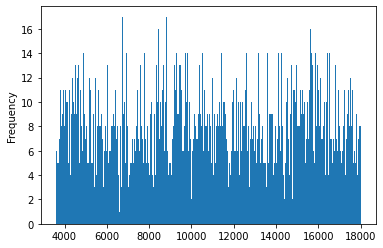

In [350]:
duration.dt.seconds.plot.hist(bins=1000)

**❓ What is the most accurate time unit to use to describe the `duration` feature?**

**📝 Choose between `['days', 'hours', 'minutes', 'seconds']` and store your choice in the `duration_time_unit` variable:**

In [351]:
# YOUR CODE HERE
duration_time_unit = 'seconds'

**📝 Create a `TimeFeaturesExtractor` class that transforms `datetime_start` and `datetime_end` into `month` and `duration`:**
- `month` as a number from 1 to 12
- `duration` as a float in the relevant `duration_time_unit`

In [352]:
# YOUR CODE HERE
class TimeFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Encode a time based features
    """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        No Precomputation ?
        """
        return self

    def transform(self, X, y=None):
        """
        Compute and returns the final DataFrame
        """
        df = X.copy()
        df['month'] = df.datetime_start.dt.month
        duration = df.datetime_end - df.datetime_start
        df['duration'] = duration.dt.seconds
       
        return df[['month', 'duration']]
    


**📝 Apply your `TimeFeaturesExtractor` to _100 rows_ of `X` and store the result in a DataFrame `X_time_features`**

Double check that it has **2 columns**: `month` and `duration`, and **100 rows**

In [353]:
# YOUR CODE HERE

X_time_features = TimeFeatureExtractor().fit_transform(X[:100])
X_time_features.shape

(100, 2)

#### Cyclical Encoding & Scaling

💡 We now have to encode and scale the extracted time features!  

You should scale the `duration` between 0 and 1.  

However we need to build a **Cyclical Encoder** for the `month`.

**📝Create a `CyclicalEncoder` class that transforms `month` into `month_cos` and `month_sin`.**

Recall the equations:  

$month\_norm = 2\pi\frac{month}{12}$  
$month\_cos = \cos({month\_norm})$  
$month\_sin = \sin({month\_norm})$

In [354]:
# YOUR CODE HERE
class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """
    Encode a cyclical feature
    """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        No compuation
        """
        return self

    def transform(self, X, y=None):
        """
        Compute and returns the final DataFrame
        """
        df = pd.DataFrame()
        df['month_cos'] =  round(np.cos(2 * math.pi / 12 * X[['month']]), 3)
        df['month_sin'] =  round(np.sin(2 * math.pi / 12 * X[['month']]), 3)
        return df

**📝 Apply your `CyclicalEncoder` to `X_time_features` and store the result in a DataFrame `X_time_cyclical`.**

Double check that it has **2 columns**: `month_cos` and `month_sin`, and **100 rows**

In [355]:
# YOUR CODE HERE
X_time_cyclical = CyclicalEncoder().fit_transform(X_time_features)

<AxesSubplot:xlabel='month_cos', ylabel='month_sin'>

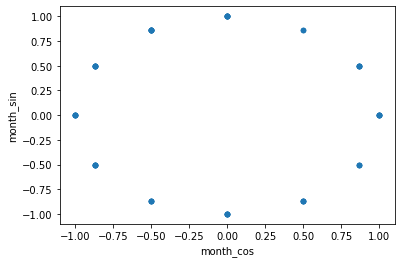

In [356]:
X_time_cyclical.plot.scatter('month_cos', 'month_sin')

**📝 Build a pipeline, that contains all the steps for time features.**

Store it in a variable `preprocessing_time`

**Steps**

- Extraction of `month` and `duration` from  `datetime_start` and `datetime_end`  
- Scaling of `duration` between 0 and 1
- Cyclical encoding of `month`

In [357]:
# YOUR CODE HERE
preprocessing_time = make_pipeline(
    TimeFeatureExtractor(),
    make_column_transformer(
        (MinMaxScaler(), ['duration']),
        (CyclicalEncoder(), ['month'])
    )
)


In [358]:
preprocessing_time.fit_transform(X[['datetime_start', 'datetime_end']])

array([[ 0.54946505, -1.        ,  0.        ],
       [ 0.90232041,  1.        , -0.        ],
       [ 0.89648465,  0.5       , -0.866     ],
       ...,
       [ 0.35910796,  0.866     ,  0.5       ],
       [ 0.45866333,  1.        , -0.        ],
       [ 0.94275393, -0.866     ,  0.5       ]])

### 💾 Save your results

Run the cell below to save your results.

In [360]:
from nbresult import ChallengeResult
results = ChallengeResult(
    'feature_engineering',
    x_soil_condition=X_soil_condition_encoded,
    X_time_features=X_time_features,
    X_time_cyclical= X_time_cyclical,
    X_time=preprocessing_time.fit_transform(X)
)
results.write()

## Advanced Pipeline

**📝  Build a full preprocessing pipeline and store it in `preprocessing_advanced`.**

Here are its steps, they should go in a parallel ColumnTransformer

- Scale all numerical features between 0 and 1
- Encode `main_element`  
- Better encode `soil_condition`
- Apply the `preprocessing_time` pipeline on `datetime_start` and `datetime_end`

In [361]:
# YOUR CODE HERE
preprocessing_advanced = make_column_transformer(
    (numeric_pipe, feat_num),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ['main_element']),
    (encoder, ['soil_condition']),
    (preprocessing_time, ['datetime_start', 'datetime_end'])
)

## Regularized Linear Model

**📝 Build a pipeline that uses `preprocessing_advanced` and then a _Regularized Linear_ model.**

Cross-validate your pipeline and store the scores in a list `scores_regularized`

In [362]:
# YOUR CODE HERE
pipeline_regularized = make_pipeline(
    preprocessing_advanced,
    LogisticRegression(max_iter=2000)
)
pipeline_regularized

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['measure_index',
                                                   'measure_moisture',
                                                   'measure_temperature',
                                                   'measure_chemicals',
                                                   'measure_biodiversity']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['main_elem...
                                                                 unknown_value=-1),
                                                  ['soil_condition']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('timefeatureextractor',
                                                                   TimeFeatureExtractor()),
                                                                  ('columntransformer',
                                                                   ColumnTransformer(transformers=[('minmaxscaler',
                                                                                                    MinMaxScaler(),
                                                                                                    ['duration']),
                                                                                                   ('cyclicalencoder',
                                                                                                    CyclicalEncoder(),
                                                                                                    ['month'])]))]),
                                                  ['datetime_start',
                                                   'datetime_end'])])),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [363]:
scores_regularized = cross_val_score(pipeline_regularized, X, y, scoring='recall', cv=5, n_jobs=-1)

In [364]:
scores_regularized

array([0.83028083, 0.81807082, 0.81051345, 0.81173594, 0.80195599])

### 💾 Save your results

Run the cell below to save your results.

In [365]:
from nbresult import ChallengeResult
from sklearn.model_selection import train_test_split
X_,X_val,y_,y_val = train_test_split(X,y,test_size=0.3,random_state=7)
pipe=pipeline_regularized.fit(X_,y_)

result = ChallengeResult(
    'advanced_pipeline',
    steps=str(pipeline_regularized.steps),
    scores=scores_regularized,
    y=y_val,
    y_pred=pipeline_regularized.predict(X_val)
)
result.write()

## Dimensionality Reduction

**📝 Add a dimensional reduction step as the last step of your `preprocessing_advanced`. Make sure your dimensional reduction keeps _only 12 features_.**

In [366]:
# YOUR CODE HERE
preprocessing_advanced = make_pipeline(
    preprocessing_advanced,
    PCA(n_components=12)
)

In [367]:
preprocessing_advanced

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['measure_index',
                                                   'measure_moisture',
                                                   'measure_temperature',
                                                   'measure_chemicals',
                                                   'measure_biodiversity']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['main_elem...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['soil_condition']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('timefeatureextractor',
                                                                   TimeFeatureExtractor()),
                                                                  ('columntransformer',
                                                                   ColumnTransformer(transformers=[('minmaxscaler',
                                                                                                    MinMaxScaler(),
                                                                                                    ['duration']),
                                                                                                   ('cyclicalencoder',
                                                                                                    CyclicalEncoder(),
                                                                                                    ['month'])]))]),
                                                  ['datetime_start',
                                                   'datetime_end'])])),
                ('pca', PCA(n_components=12))])

**📝 Apply your `preprocessing_advanced` to `X` and store the result in the `X_preproc_adv` variable.**

In [368]:
# YOUR CODE HERE
X_preproc_adv = preprocessing_advanced.fit_transform(X)
X_preproc_adv.shape

(8138, 12)

### 💾 Save your results

Run the cell below to save your results.

In [369]:
from nbresult import ChallengeResult
results=ChallengeResult(
    'unsupervised',
    algorithm=preprocessing_advanced.steps[-1],
    X_preproc_adv=X_preproc_adv
)
results.write()

## Non-linear Model

**📝 Build a pipeline that uses `preprocessing_advanced` and then a _Ensemble_ model.**

Store this pipeline in the variable `pipeline_ensemble`

Cross-validate your pipeline and store the scores in a list `scores_ensemble`

In [370]:
# YOUR CODE HERE
pipeline_ensemble = make_pipeline(
    preprocessing_advanced,
    RandomForestClassifier()
)
pipeline_ensemble

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['measure_index',
                                                                    'measure_moisture',
                                                                    'measure_temperature',
                                                                    'measure_chemicals',
                                                                    'measure_biodiversity']),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignor...
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('timefeatureextractor',
                                                                                    TimeFeatureExtractor()),
                                                                                   ('columntransformer',
                                                                                    ColumnTransformer(transformers=[('minmaxscaler',
                                                                                                                     MinMaxScaler(),
                                                                                                                     ['duration']),
                                                                                                                    ('cyclicalencoder',
                                                                                                                     CyclicalEncoder(),
                                                                                                                     ['month'])]))]),
                                                                   ['datetime_start',
                                                                    'datetime_end'])])),
                                 ('pca', PCA(n_components=12))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [371]:
scores_ensemble = cross_val_score(pipeline_ensemble, X, y, scoring='recall', cv=5, n_jobs=-1)

In [372]:
print(scores_ensemble)
scores_ensemble.mean()

[0.96092796 0.96336996 0.96821516 0.96821516 0.96943765]


0.9660331789916142

**❓ Does this non-linear model satisfy the goal of the study?**

Yes. Each recall value in the cross validation is above 90%

💡 Wait, did our feature engineering helps us ❓

**📝 Build a pipeline that uses `preprocessing_basic` and the same Ensemble model as above.**

In [373]:
basic_rf_pipeline = make_pipeline(
    preprocessing_basic,
    RandomForestClassifier()
)
basic_rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['main_element',
                                                   'soil_condition']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['measure_index',
                                                   'measure_moisture',
                                                   'measure_temperature',
                                                   'measure_chemicals',
                                                   'measure_biodiversity'])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [374]:
simple_rf_scores = cross_val_score(basic_rf_pipeline, X, y, scoring='recall', cv=5, n_jobs=-1)
simple_rf_scores

array([0.76312576, 0.77045177, 0.75794621, 0.73594132, 0.74572127])

**❓ What is your conclusion?**

Thee feature engineering was worth the effort. It allowed to increase notably the recall from 75% to above 95%

### 💾 Save your results

Run the cell below to save your results.

In [376]:
from nbresult import ChallengeResult
from sklearn.model_selection import train_test_split
X_,X_val,y_,y_val=train_test_split(X,y,test_size=0.3,random_state=7)
pipeline_ensemble.fit(X_,y_)
y_pred=pipeline_ensemble.predict(X_val)

results=ChallengeResult(
    'ensemble',
    steps=str(pipeline_ensemble.steps),
    scores=scores_ensemble,
    y=y_val,
    y_pred=y_pred
)
results.write()

## Fine-Tuning

💡 To improve the model as much as we can, it's time to grid search for optimal hyperparameters

**📝 Look at the hyperparameters of your estimator**

In [258]:
# YOUR CODE HERE
pipeline_ensemble.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('columntransformer',
                    ColumnTransformer(transformers=[('pipeline-1',
                                                     Pipeline(steps=[('simpleimputer',
                                                                      SimpleImputer()),
                                                                     ('minmaxscaler',
                                                                      MinMaxScaler())]),
                                                     ['measure_index',
                                                      'measure_moisture',
                                                      'measure_temperature',
                                                      'measure_chemicals',
                                                      'measure_biodiversity']),
                                                    ('onehotencoder',
                                                     OneH

**📝 Try to fine tune some hyperparameters to improve your model!**

In [259]:
# YOUR CODE HERE
params = {
    'pipeline__columntransformer__pipeline-1__simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'randomforestclassifier__n_estimators': [100, 300, 500],
    'randomforestclassifier__max_features': [4, 6, 8]
}

**📝 Store the _fitted_ grid search in the `search` variable:**

In [ ]:
# YOUR CODE HERE
search = GridSearchCV(pipeline_ensemble, 
                      params, 
                      scoring='recall', cv=5, n_jobs=-1)

In [264]:
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('columntransformer',
                                                         ColumnTransformer(transformers=[('pipeline-1',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('minmaxscaler',
                                                                                                           MinMaxScaler())]),
                                                                                          ['measure_index',
                                                                                           'measure_moisture',
                                                                                           'measure_temperature',
                                                                                           'measure_chemicals',
                                                                                           'measure_biodiversity']),
                                                                                         ('onehotencoder',
                                                                                          OneHotE...
                                                                                          ['datetime_start',
                                                                                           'datetime_end'])])),
                                                        ('pca',
                                                         PCA(n_components=12))])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'pipeline__columntransformer__pipeline-1__simpleimputer__strategy': ['mean',
                                                                                              'median',
                                                                                              'most_frequent'],
                         'randomforestclassifier__max_features': [4, 6, 8],
                         'randomforestclassifier__n_estimators': [100, 300,
                                                                  500]},
             scoring='recall')

**📝 Store the _cross-validated results_ of your grid search in the `cv_results` variable:**

In [377]:
# YOUR CODE HERE
cv_results = search.cv_results_

**📝 Store the _best model_ of your grid search in a variable `tuned_model`.**

In [378]:
# YOUR CODE HERE
search.best_params_

{'pipeline__columntransformer__pipeline-1__simpleimputer__strategy': 'most_frequent',
 'randomforestclassifier__max_features': 8,
 'randomforestclassifier__n_estimators': 300}

In [379]:
tuned_model = search.best_estimator_.fit(X, y)

### 💾 Save your results

Run the cell below to save your results.

In [380]:
from nbresult import ChallengeResult
from sklearn.model_selection import train_test_split
X_,X_val,y_,y_val=train_test_split(X,y,test_size=0.3,random_state=10)
tuned_model.fit(X_,y_)

result = ChallengeResult(
    'model_tuning',
    scores_ensemble=scores_ensemble,
    scoring=search.scorer_,
    params=search.best_params_,
    cv_results=cv_results,
    y=y_val,
    y_pred=tuned_model.predict(X_val)
)
result.write()

## Prediction

**📝 Use your newly fine-tuned model to predict on a test set.**

Load the test provided at this url: "https://wagon-public-datasets.s3.amazonaws.com/certification/soils_viability/soils_viability_test.csv".

Create `X_test` and `y_test`

Use your fine-tuned model to predict on `X_test`

Print a full classification report with your prediction and `y_test`

In [381]:
df_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification/soils_viability/soils_viability_test.csv")

In [382]:
# YOUR CODE HERE
y_test = df_test.target
X_test = df_test.drop(['target'], axis=1)

In [387]:
X_test.datetime_end = pd.to_datetime(X_test.datetime_end)
X_test.datetime_start = pd.to_datetime(X_test.datetime_start)

In [391]:
y_pred = tuned_model.predict(X_test)

In [393]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1036
           1       0.99      0.97      0.98      1000

    accuracy                           0.98      2036
   macro avg       0.98      0.98      0.98      2036
weighted avg       0.98      0.98      0.98      2036



**❓ Comment your results:**

With a recall of 97% for prediction of the positive class and an average value of 98% in precision, the model is highly effective in predicting the soil quality. 

We efficiently detect 97% of actual good soils, while keeping the number of false positive to roughly 2%

## API 

Time to put a pipeline in production!

👉 Go back to the certification interface and follow the instructions about the API challenge.

**This final part is independent from the above notebook**